# EuroBasket 2025 Team Analytics

This notebook explores team-level performance in EuroBasket 2025 using advanced metrics and modeling techniques. We begin by engineering a composite score to rank teams, then expand into clustering, predictive modeling, and style analysis.

Each section builds on the previous one to uncover deeper insights into team behavior, success factors, and strategic profiles.

## Section 1: Composite Score Ranking

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('eurobasket_team_stats.csv',delimiter=';')

# Preview
df.head()

,#,Teams,GP,MPG,PTS,2PM-2PA,2P%,3PM-3PA,3P%,FTM-FTA,...,ORTG,DRTG,EFG%,DREB%,OREB%,FTRATE,AST%,PACE 40,PACE 48,STOCKS
0,19,Belgium,5,200,363,81-179,45.3,47-124,37.9,60-93,...,99.2,110.7,50.0,68.3,28.5,30.7,23.0,73.2,87.8,8.2
1,15,Bosnia and Herzegovina,6,200,473,116-208,55.8,57-178,32.0,70-115,...,110.3,112.4,52.2,68.6,35.0,29.8,28.0,71.5,85.8,9.8
2,24,Cyprus,5,200,295,74-168,44.0,39-139,28.1,30-39,...,85.0,130.3,43.2,62.2,22.5,12.7,19.6,69.4,83.3,6.2
3,23,Czechia,5,200,338,68-135,50.4,52-181,28.7,46-68,...,93.4,119.6,46.2,63.2,26.2,21.5,26.8,72.4,86.9,7.8
4,22,Estonia,5,200,352,78-169,46.2,46-147,31.3,58-79,...,98.9,111.8,46.5,70.1,28.4,25.0,27.2,71.2,85.4,6.8


In [5]:
# Strip column names
df.columns = df.columns.str.strip()

# Split composite columns
df[['2PM', '2PA']] = df['2PM-2PA'].str.split('-', expand=True).astype(float)
df[['3PM', '3PA']] = df['3PM-3PA'].str.split('-', expand=True).astype(float)
df[['FTM', 'FTA']] = df['FTM-FTA'].str.split('-', expand=True).astype(float)
df[['FGM_PG', 'FGA_PG']] = df['FGMPG-FGAPG'].str.split('-', expand=True).astype(float)
df[['3PM_PG', '3PA_PG']] = df['3PMPG-3PAPG'].str.split('-', expand=True).astype(float)
df[['FTM_PG', 'FTA_PG']] = df['FTMPG-FTAPG'].str.split('-', expand=True).astype(float)

# Drop originals
df.drop(columns=[
    '2PM-2PA', '3PM-3PA', 'FTM-FTA',
    'FGMPG-FGAPG', '3PMPG-3PAPG', 'FTMPG-FTAPG'
], inplace=True)

In [6]:
# Create point differential
df['PPG_diff'] = df['PPG'] - df['PAPG']

# Define weights
weights = {
    'NETRTG': 0.4,
    'EFFPG': 0.3,
    'PPG_diff': 0.2,
    'AST/TO': 0.1
}

# Calculate composite score
df['Score'] = (
    weights['NETRTG'] * df['NETRTG'] +
    weights['EFFPG'] * df['EFFPG'] +
    weights['PPG_diff'] * df['PPG_diff'] +
    weights['AST/TO'] * df['AST/TO']
)

In [7]:
# Sort and display top teams
df_ranked = df[['Teams', 'Score', 'NETRTG', 'EFFPG', 'PPG', 'PAPG', 'AST/TO']].sort_values(by='Score', ascending=False)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked.head(10)

,Teams,Score,NETRTG,EFFPG,PPG,PAPG,AST/TO
0,Germany,54.42,31.7,122.4,99.9,75.9,2.2
1,Türkiye,44.93,21.6,109.9,90.2,74.5,1.8
2,Serbia,39.91,13.2,108.2,86.7,76.7,1.7
3,France,38.31,13.8,102.0,88.5,78.5,1.9
4,Greece,36.03,11.3,99.3,84.8,76.9,1.4
5,Lithuania,34.68,8.7,100.1,85.0,79.9,1.5
6,Italy,34.46,13.7,89.8,78.8,69.5,1.8
7,Slovenia,32.85,4.6,101.3,92.0,89.7,1.6
8,Spain,32.53,10.2,88.4,79.4,70.8,2.1
9,Finland,32.22,3.7,100.0,87.3,84.5,1.8


C:\Users\melis\AppData\Local\Temp\ipykernel_66776\1864899854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')


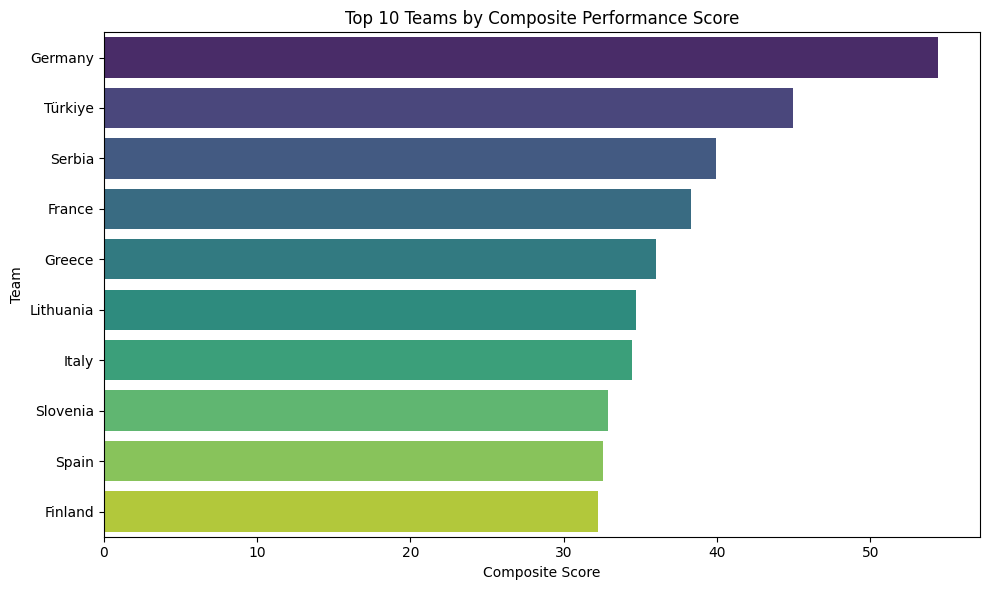

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')
plt.title('Top 10 Teams by Composite Performance Score')
plt.xlabel('Composite Score')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

## 🧠 Summary of Findings

- Germany ranks highest due to elite NETRTG, EFFPG, and ball control.
- Türkiye and Serbia follow with strong scoring margins and efficiency.
- Teams with balanced offense, defense, and possession metrics rise to the top.
- AST/TO adds nuance, helping differentiate teams with similar scoring profiles.

## Explanation of Composite Score Results

The composite score blends NETRTG, EFFPG, PPG - PAPG, and AST/TO to rank teams holistically. 
Germany’s dominance stems from high values across all metrics, while other teams rise or fall based 
on specific strengths or weaknesses. This score highlights well-rounded performance and sets the stage 
for clustering and predictive modeling.

## Section 2: Clustering Teams by Style

In this section, we use unsupervised learning to group teams based on stylistic features. This helps identify strategic archetypes and compare teams beyond performance rankings.

In [10]:
# Choose stylistic features

features = [
    'PACE 40',     # Tempo
    'AST%',        # Ball movement
    '3P%',         # Shooting style
    'FT%',         # Free throw efficiency
    'RPG',         # Rebounding
    'STLPG',       # Defensive aggression
    'BLKPG',       # Rim protection
    'AST/TO',      # Ball control
    'TOPG'         # Turnover tendency
]

# Subset and preview

X = df[features].copy()
X.head()

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
0,73.2,23.0,37.9,64.5,35.6,5.2,2.8,1.1,15.0
1,71.5,28.0,32.0,60.9,37.2,7.5,2.2,1.5,13.2
2,69.4,19.6,28.1,76.9,31.0,5.8,0.6,1.0,14.0
3,72.4,26.8,28.7,67.6,32.2,5.6,2.2,1.4,14.4
4,71.2,27.2,31.3,73.4,34.2,6.0,0.8,1.5,13.0


## Feature Distributions  
Before clustering, we examine how each stylistic feature is distributed across teams.
This helps validate their inclusion and reveals potential skewness or outliers.

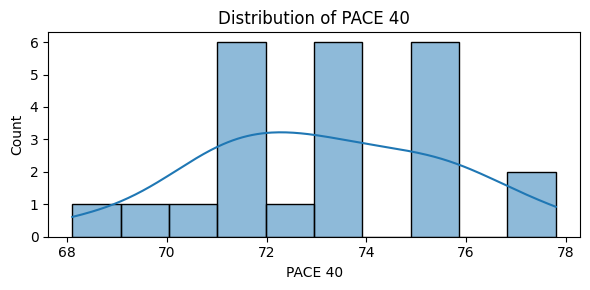

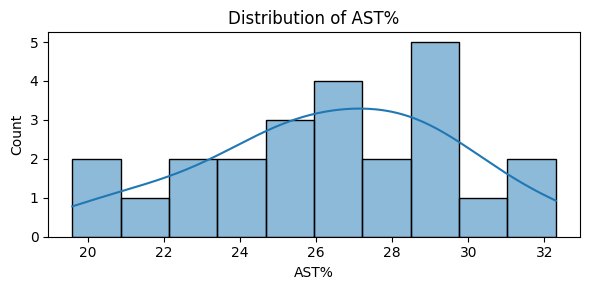

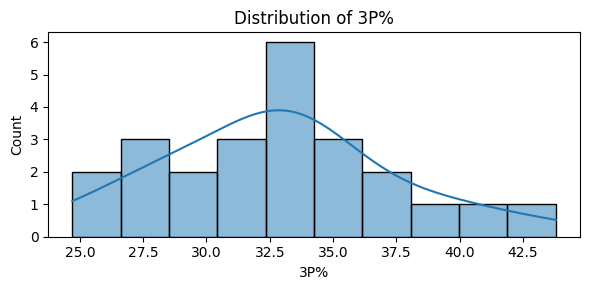

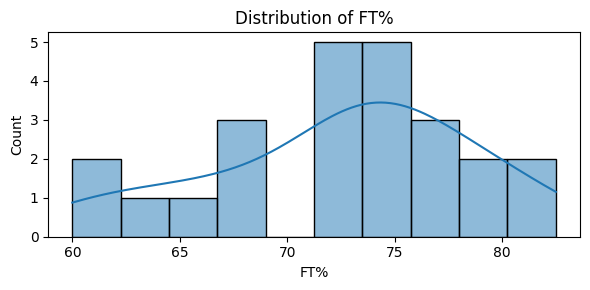

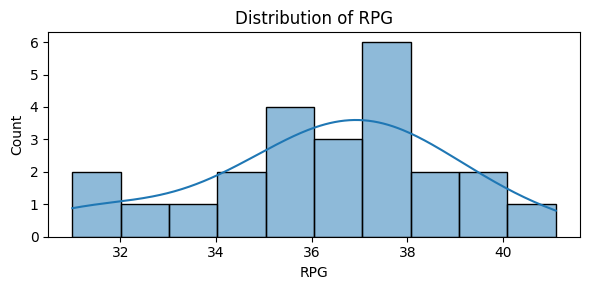

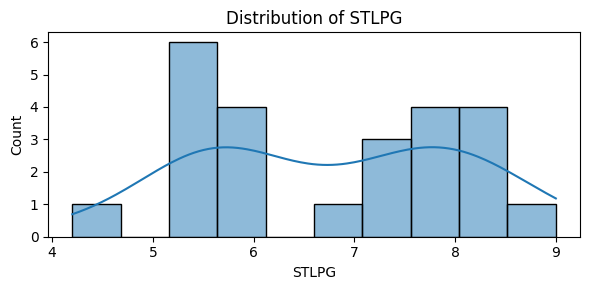

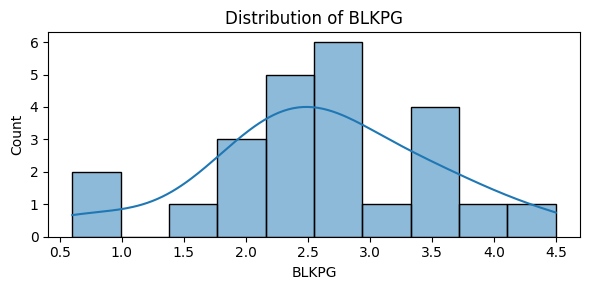

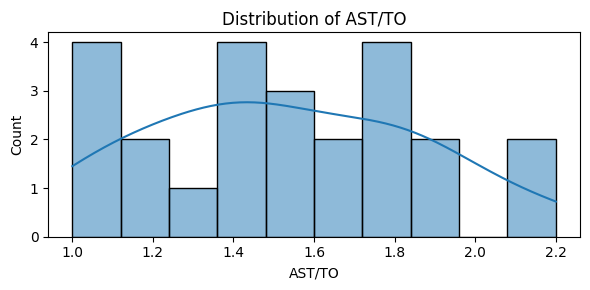

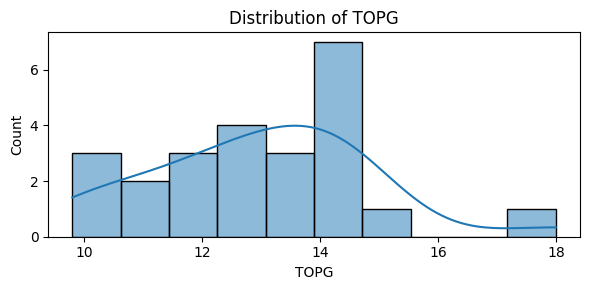

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

## Interpretation of Stylistic Feature Distributions (PACE 40, AST%, 3P%, FT%)

These four metrics reveal foundational aspects of team-level strategy:

- **PACE 40**: Most teams operate between 72–74 possessions per 40 minutes, with a few pushing above 75. This suggests a general preference for moderate tempo, with some teams favoring high-speed transition play.

- **AST%**: The distribution peaks around 27–28%, indicating that most teams rely on structured ball movement. A few teams fall below 24%, suggesting more isolation-heavy or individualistic offensive systems.

- **3P%**: Teams cluster between 30–36%, with a few outliers above 38%. This reflects a balanced reliance on perimeter shooting, with some teams clearly emphasizing spacing and off-ball movement.

- **FT%**: The spread ranges from ~60% to ~80%, showing broader variability in free throw execution. While not a primary stylistic driver, FT% reflects scoring reliability and composure under pressure.

- **RPG (Rebounds Per Game)**: The distribution ranges from ~31 to ~41, with a peak around 37–38. This suggests that while most teams are competitive on the glass, a few stand out as dominant rebounders. Rebounding is a key stylistic marker for teams that emphasize interior control and second-chance opportunities.

- **STLPG (Steals Per Game)**: Most teams fall between 5 and 7 steals per game, with a peak around 6. A few teams push above 8, indicating aggressive defensive schemes that prioritize ball pressure and disruption. These teams likely rely on forcing turnovers to fuel transition offense.

- **BLKPG (Blocks Per Game)**: The distribution ranges from ~0.5 to ~4.5, with a peak around 2.5. This suggests most teams generate a moderate number of blocks, while a few stand out with strong rim protection. High BLKPG values often reflect interior defensive schemes and physical frontcourt presence.

- **AST/TO (Assist-to-Turnover Ratio)**: Most teams fall between 1.2 and 1.6, with a peak around 1.4. This indicates that while teams generally maintain decent possession discipline, only a few achieve elite efficiency. AST/TO is a key marker of offensive structure and decision-making quality.

- **TOPG (Turnovers Per Game)** reflects possession control and offensive discipline. The distribution ranges from ~10 to ~18, with a clear peak around 14. This suggests most teams commit a moderate number of turnovers, but a few are notably more error-prone. High TOPG values often indicate chaotic offensive execution, poor spacing, or forced playmaking under pressure. In contrast, teams with lower TOPG tend to operate with structured sets and better decision-making. This metric is essential for distinguishing between disciplined systems and turnover-heavy styles.






These distributions show meaningful variation across teams and validate the inclusion of these features in clustering. They help distinguish between tempo-driven systems, pass-heavy offenses, and shooting-oriented strategies.

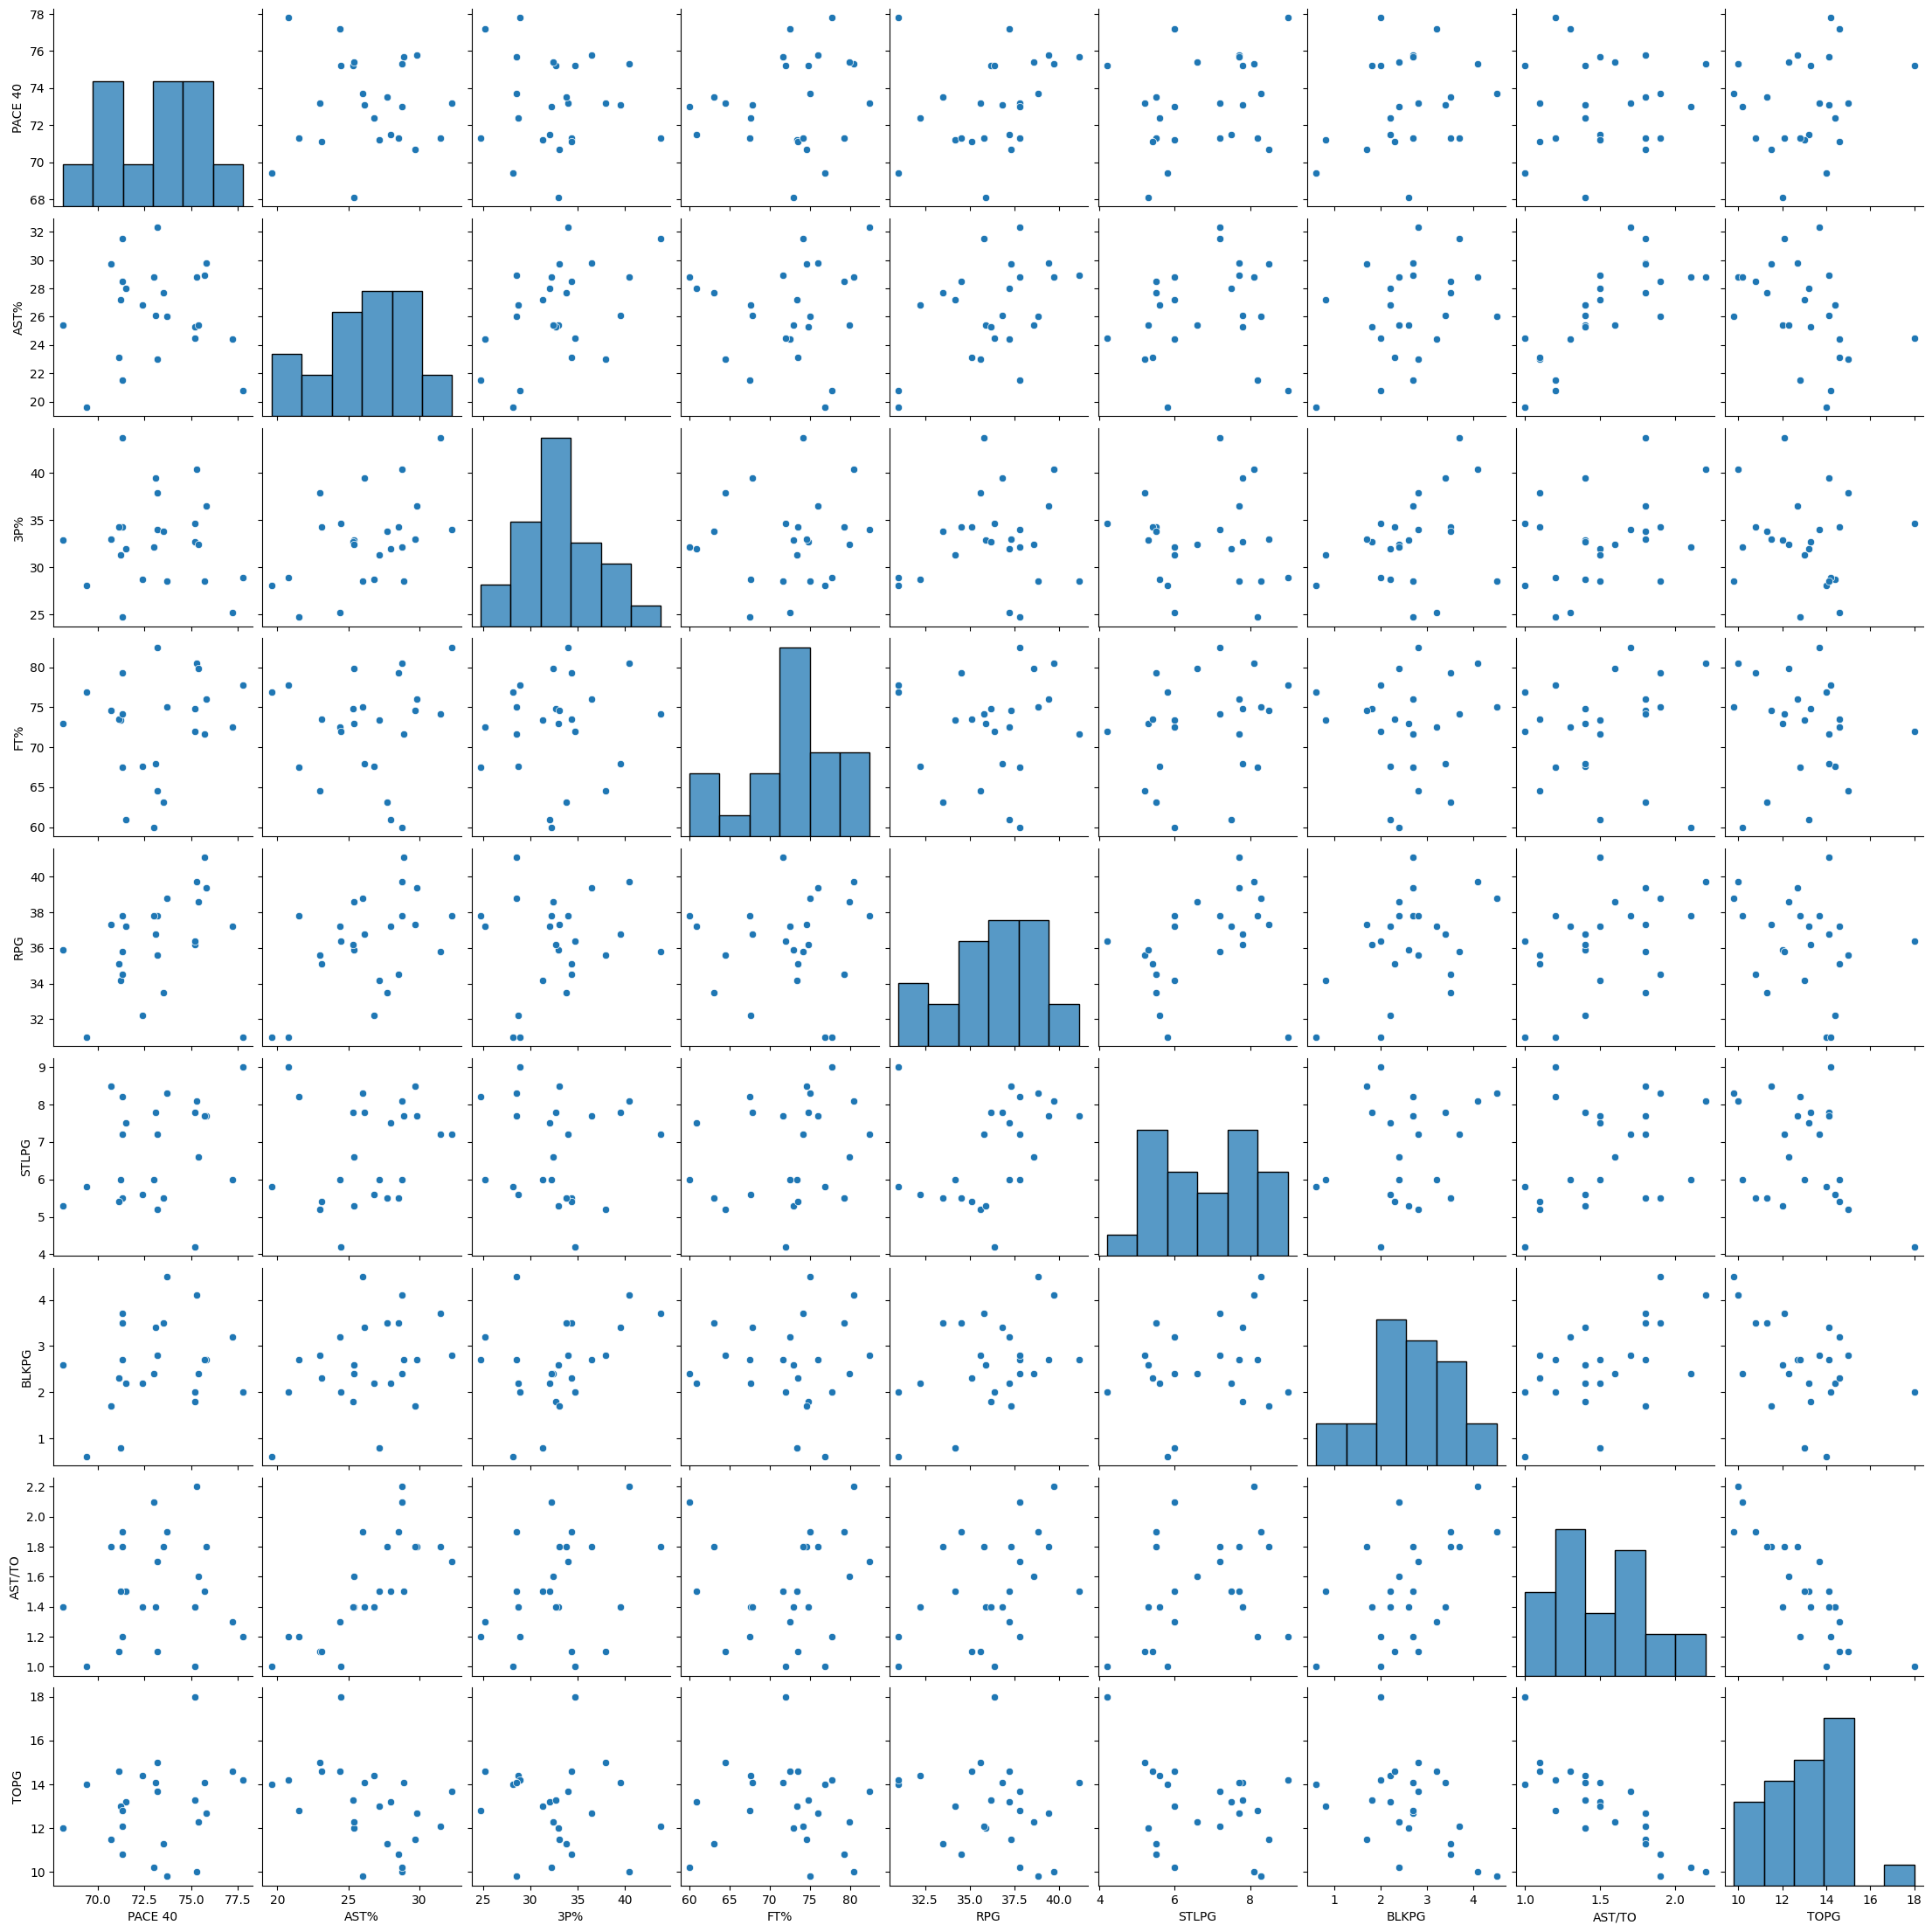

In [23]:
sns.pairplot(df[features])

## Interpretation of Pairwise Feature Relationships

The pairplot reveals several key relationships across stylistic metrics:

- **AST/TO vs. TO/G** shows a clear negative trend — teams with higher assist-to-turnover efficiency tend to commit fewer turnovers. This confirms that both metrics capture complementary aspects of possession discipline.

- **PACE vs. shooting metrics (3P%, FT%)** shows no strong correlation, suggesting that tempo does not directly dictate shooting efficiency. Fast-paced teams may rely on transition scoring, while slower teams may focus on half-court execution.

- **RPG vs. SPG/BPG** shows mild positive associations, indicating that teams strong on the glass often also generate defensive events. These teams likely emphasize physicality and interior control.

- **FT% and 3P%** appear largely independent, reinforcing that free throw and perimeter shooting reflect different skill sets and tactical roles.

Overall, the pairplot confirms that the selected features offer diverse, non-redundant signals. Each contributes uniquely to team style, supporting their inclusion in clustering and validating the multidimensional nature of the analysis.

## Feature Selection Rationale  
We selected features that capture team-level stylistic behavior:  
- **PACE 40**: Tempo and possession volume  
- **AST% / AST/TO / TOPG**: Ball movement and control  
- **3P% / FT%**: Shooting efficiency  
- **RPG / STLPG / BLKPG**: Defensive and rebounding activity  
These metrics reflect how teams play, not just how well they perform.

In [13]:
# Standardize Features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Choosing the Number of Clusters

To determine the optimal number of clusters, we use the elbow method. 
This helps identify the point where adding more clusters yields diminishing returns in explaining variance.

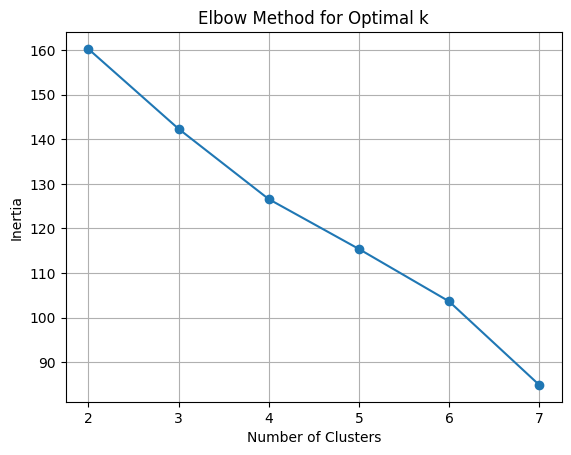

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [24]:
#Apply KMeans Clustering

from sklearn.cluster import KMeans

# Choose number of clusters 4(elbow method)
kmeans = KMeans(n_clusters=4, random_state=42)
df['StyleCluster'] = kmeans.fit_predict(X_scaled)

In [25]:
# Show cluster labels
df[['Teams', 'StyleCluster']].sort_values(by='StyleCluster')

,Teams,StyleCluster
6,France,0
5,Finland,0
8,Germany,0
19,Serbia,0
20,Slovenia,0
23,Türkiye,0
21,Spain,1
14,Latvia,1
22,Sweden,1
13,Italy,2


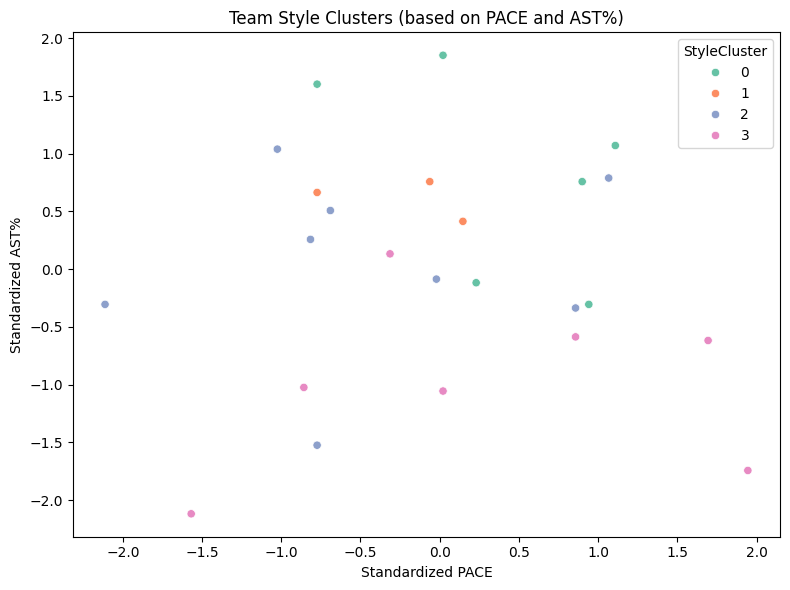

In [26]:
#Plot Clusters

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['StyleCluster'], palette='Set2')
plt.title('Team Style Clusters (based on PACE and AST%)')
plt.xlabel('Standardized PACE')
plt.ylabel('Standardized AST%')
plt.tight_layout()
plt.show()

In [27]:
#Cluster Summary Table

df.groupby('StyleCluster')[features].mean().round(2)

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
StyleCluster,,,,,,,,,
0,74.12,28.97,35.93,78.02,38.35,7.52,3.37,1.83,11.77
1,72.60,28.33,33.43,67.47,35.27,5.67,3.13,1.93,10.77
2,72.10,26.51,31.82,70.47,37.06,7.35,2.24,1.46,13.00
3,73.76,23.17,31.11,72.11,34.07,5.89,2.16,1.16,14.97


## Interpretation of Style Clusters (K = 4)

Based on the clustering results, we identify four distinct team styles:

### 🧠 Cluster 0 – Balanced Playmakers with Defensive Bite
- **High PACE (74.12)** and **AST% (28.97)** → Fast tempo with strong ball movement
- **Elite 3P% (35.93)** and **FT% (78.02)** → Efficient scoring across zones
- **Top-tier RPG, STLPG, BLKPG** → Physical and disruptive defense
- **Strong AST/TO (1.83)** → Disciplined execution
- **Moderate TOPG (11.77)** → Controlled possessions

> These teams combine pace, precision, and defensive aggression — likely contenders with well-rounded systems.

---

### 🧩 Cluster 1 – Structured Efficiency with Low Turnovers
- **Moderate PACE (72.60)** and **AST% (28.33)** → Controlled tempo with solid ball sharing
- **Average shooting metrics** → Less reliant on perimeter or FT scoring
- **Lower STLPG and BLKPG** → Conservative defense
- **Best AST/TO (1.93)** and **Lowest TOPG (10.77)** → Elite possession discipline

> These teams prioritize structure and efficiency over flair — low-risk, high-control systems.

---

### 🔥 Cluster 2 – Physical Disruptors with Scoring Gaps
- **Lower AST% (26.51)** and **3P% (31.82)** → Less ball movement and perimeter threat
- **Strong RPG, STLPG** → Physical presence and defensive pressure
- **Mid-tier AST/TO (1.46)** and **High TOPG (13.00)** → Some execution issues

> These teams rely on hustle and disruption but may struggle with offensive fluidity.

---

### ⚡ Cluster 3 – High-Paced Chaos with Turnover Risk
- **High PACE (73.76)** but **Lowest AST% (23.17)** → Fast tempo, minimal ball sharing
- **Weak shooting metrics** → Inefficient scoring
- **Low AST/TO (1.16)** and **Highest TOPG (14.97)** → Turnover-prone systems

> These teams play fast and loose — aggressive but error-prone, likely relying on transition and individual creation.

---

Each cluster reflects a distinct tactical identity, offering valuable insight for scouting, matchup analysis, or predictive modeling.